In [18]:
import nest_asyncio
nest_asyncio.apply()
import os
import csv
from telethon import TelegramClient, events
from datetime import datetime

# Remove old session to force fresh login each time
if os.path.exists('bot_session.session'):
    os.remove('bot_session.session')

api_id = '28932578'
api_hash = 'e73796fdffd4d3fa973e1aedbe803311'
bot_token = '8315747892:AAHpfpYvvuC9lXBpycHHOBarC8_DTvOV0fs'  # Your bot token

client = TelegramClient('bot_session', api_id, api_hash)

# CSV file name
csv_file = 'flagged_messages.csv'

# Initialize CSV file with headers (only once)
if not os.path.exists(csv_file):
    with open(csv_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['timestamp', 'sender_id', 'message'])

async def main():
    await client.start(bot_token=bot_token)

    @client.on(events.NewMessage)
    async def handler(event):
        msg = event.message.message
        sender = await event.get_sender()
        sender_id = sender.id if sender else 'Unknown'
        timestamp = event.message.date.strftime("%Y-%m-%d %H:%M:%S")

        print(f"New message from {sender_id} at {timestamp}: {msg}")

        # Append message data to CSV
        with open(csv_file, 'a', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow([timestamp, sender_id, msg])

    print("Bot is running and saving messages to", csv_file)
    await client.run_until_disconnected()

await main()


Bot is running and saving messages to flagged_messages.csv
New message from 8432945463 at 2025-10-24 07:00:11: hii what do you need
New message from 8432945463 at 2025-10-24 07:00:15: weed
New message from 8432945463 at 2025-10-24 07:00:19: or cocaine
New message from 8432945463 at 2025-10-24 07:00:31: we are currently out of stock
New message from 8432945463 at 2025-10-24 07:00:41: will notify once we are full


CancelledError: 

In [19]:
import pandas as pd
import re

# Load your saved messages
df = pd.read_csv('flagged_messages.csv')

# Basic cleaning function
def clean_text(text):
    text = str(text)
    text = re.sub(r'http\S+', '', text)       # Remove URLs
    text = re.sub(r'@\S+', '', text)          # Remove mentions
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special chars
    text = text.lower().strip()               # Lowercase and trim
    return text

df['clean_message'] = df['message'].apply(clean_text)
df.to_csv('cleaned_messages.csv', index=False)
df.head()

,timestamp,sender_id,message,clean_message
0,2025-10-24 06:55:03,8432945463,weed,weed
1,2025-10-24 07:00:11,8432945463,hii what do you need,hii what do you need
2,2025-10-24 07:00:15,8432945463,weed,weed
3,2025-10-24 07:00:19,8432945463,or cocaine,or cocaine
4,2025-10-24 07:00:31,8432945463,we are currently out of stock,we are currently out of stock


In [20]:
# Define your suspicious keywords list
keywords = ['drug', 'cocaine', 'weed', 'lsd', 'ecstasy', 'heroin', 'meth']

def is_suspicious(text):
    text = str(text).lower()
    return any(word in text for word in keywords)

# Ensure you have a message column (often 'message' or 'clean_message')
if 'clean_message' in df.columns:
    text_col = 'clean_message'
elif 'message' in df.columns:
    text_col = 'message'
else:
    raise ValueError("No column with message text found!")

# Create the suspicious column
df['suspicious'] = df[text_col].apply(is_suspicious)

# Now you can proceed with your analysis using df['suspicious']
print(df[['message', 'suspicious']].head())


                         message  suspicious
0                           weed        True
1           hii what do you need       False
2                           weed        True
3                     or cocaine        True
4  we are currently out of stock       False


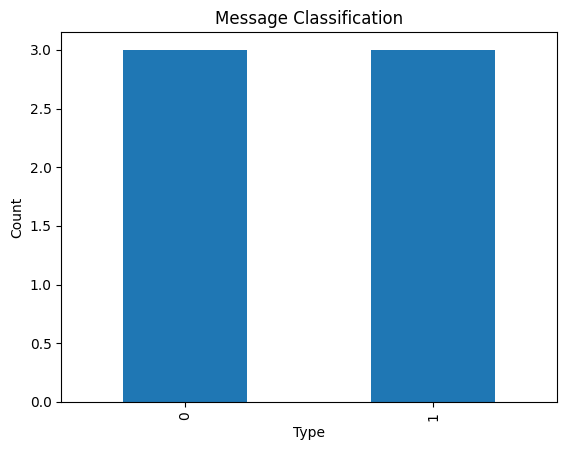

In [21]:
import matplotlib.pyplot as plt

# Ensure suspicious column is int
df['suspicious'] = df['suspicious'].astype(int)

# Get counts of both classes (0 and 1).
# Use reindex to ensure both 0 and 1 appear, even if one count is missing (will fill 0 count)
counts = df['suspicious'].value_counts().reindex([0,1], fill_value=0)

# Plot with correct tick labels matching counts
counts.plot(kind='bar', tick_label=['Normal', 'Suspicious'])

plt.title('Message Classification')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()



In [22]:
df['sender_id'].value_counts().head()


sender_id
8432945463    6
Name: count, dtype: int64

In [23]:
print(df.columns)

Index(['timestamp', 'sender_id', 'message', 'clean_message', 'suspicious'], dtype='object')


In [24]:
df.to_csv('cleaned_messages.csv', index=False)


In [25]:

import pandas as pd

df = pd.read_csv('cleaned_messages.csv')  # Use your actual filename
print(df.columns)


Index(['timestamp', 'sender_id', 'message', 'clean_message', 'suspicious'], dtype='object')


In [26]:
print(df[['message','suspicious']].head())
df['suspicious']  # All suspicious messages


                         message  suspicious
0                           weed           1
1           hii what do you need           0
2                           weed           1
3                     or cocaine           1
4  we are currently out of stock           0


0    1
1    0
2    1
3    1
4    0
5    0
Name: suspicious, dtype: int64

In [27]:
df['suspicious'] = df['suspicious'].astype(int)


In [28]:
df = pd.read_csv('cleaned_messages.csv')
X = df['clean_message']
y = df['suspicious']
print (X)
print("----------------------------")
print(y)


0                             weed
1             hii what do you need
2                             weed
3                       or cocaine
4    we are currently out of stock
5     will notify once we are full
Name: clean_message, dtype: object
----------------------------
0    1
1    0
2    1
3    1
4    0
5    0
Name: suspicious, dtype: int64


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Load and prepare data
df = pd.read_csv('cleaned_messages.csv')
# Assume 'suspicious' column exists (1=suspicious, 0=normal)
X = df['clean_message']
y = df['suspicious']

# Vectorize text
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train basic model
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\Sristi\OneDrive\Major Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sristi\OneDrive\Major Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sristi\OneDrive\Major Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [30]:
import hashlib

# For each suspicious message, compute hash and (optionally) store/send it
df = df[df['suspicious'] == 1]
df['message_hash'] = df['message'].apply(lambda x: hashlib.sha256(str(x).encode('utf-8')).hexdigest())
df.to_csv('suspicious_messages_with_hash.csv', index=False)

# Display hashes for evidence
print(df[['message', 'message_hash']].head())
print(df.columns)

      message                                       message_hash
0        weed  d132e4bc948e1cc12383afe9439fdee37eaf63dba30416...
2        weed  d132e4bc948e1cc12383afe9439fdee37eaf63dba30416...
3  or cocaine  7bdda8bff4a42183abc1ba8144a5278607c1b9ab9333e6...
Index(['timestamp', 'sender_id', 'message', 'clean_message', 'suspicious',
       'message_hash'],
      dtype='object')


In [32]:
import hashlib

# Add a tamper-proof hash column for each suspicious message
df['message_hash'] = df['message'].apply(lambda x: hashlib.sha256(str(x).encode('utf-8')).hexdigest())
df[['message','message_hash']].head()

,message,message_hash
0,weed,d132e4bc948e1cc12383afe9439fdee37eaf63dba30416...
2,weed,d132e4bc948e1cc12383afe9439fdee37eaf63dba30416...
3,or cocaine,7bdda8bff4a42183abc1ba8144a5278607c1b9ab9333e6...


c:\Users\Sristi\OneDrive\Major Project\venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


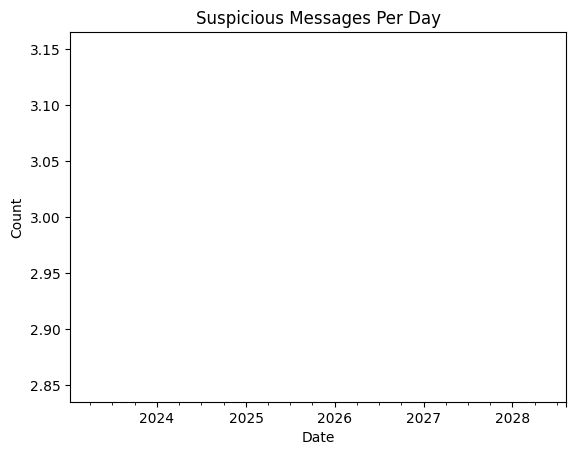

In [33]:
# Messages over time
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.resample('D')['suspicious'].sum().plot(kind='line', title='Suspicious Messages Per Day')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()


c:\Users\Sristi\OneDrive\Major Project\venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


Text(0.5, 1.0, 'Suspicious')

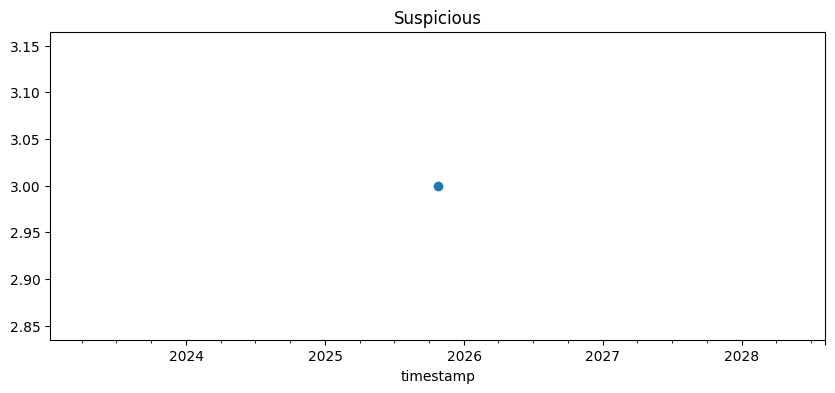

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (make sure you have 'timestamp' and 'suspicious' columns)
df = pd.read_csv('cleaned_messages.csv')  # or your relevant CSV
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['suspicious'] = df['suspicious'].astype(int)
df.set_index('timestamp', inplace=True)
# Group and sum flagged messages per day
daily = df.resample('D')['suspicious'].sum()

plt.figure(figsize=(10,4))
daily.plot(kind='line', marker='o')
plt.title('Suspicious')


In [35]:
import pandas as pd
import hashlib

# Load your messages
df = pd.read_csv('cleaned_messages.csv')

# Create hashes
df['message_hash'] = df.apply(
    lambda row: hashlib.sha256(
        f"{row['message']}|{row['timestamp']}|{row['sender_id']}".encode()
    ).hexdigest(), 
    axis=1
)

# Save to CSV
df[['message_hash', 'sender_id', 'timestamp']].to_csv('hashes_to_store.csv', index=False)
print(f"Created {len(df)} message hashes!")


Created 6 message hashes!


In [36]:
from web3 import Web3
import json
import pandas as pd

# Connect to your blockchain (Remix VM)
w3 = Web3(Web3.HTTPProvider('http://127.0.0.1:7545'))

# Your contract address
contract_address = '0xaE036c65C649172b43ef7156b009c6221B596B8b'

# Your contract ABI (paste from Remix)
contract_abi = [
        {
                "anonymous": False,
                "inputs": [
                        {
                                "indexed": True,
                                "internalType": "uint256",
                                "name": "messageId",
                                "type": "uint256"
                        },
                        {
                                "indexed": False,
                                "internalType": "string",
                                "name": "messageHash",
                                "type": "string"
                        },
                        {
                                "indexed": True,
                                "internalType": "address",
                                "name": "sender",
                                "type": "address"
                        },
                        {
                                "indexed": False,
                                "internalType": "uint256",
                                "name": "timestamp",
                                "type": "uint256"
                        }
                ],
                "name": "MessageStored",
                "type": "event"
        },
        {
                "inputs": [],
                "name": "getAllMessages",
                "outputs": [
                        {
                                "components": [
                                        {
                                                "internalType": "string",
                                                "name": "messageHash",
                                                "type": "string"
                                        },
                                        {
                                                "internalType": "uint256",
                                                "name": "timestamp",
                                                "type": "uint256"
                                        },
                                        {
                                                "internalType": "address",
                                                "name": "sender",
                                                "type": "address"
                                        },
                                        {
                                                "internalType": "string",
                                                "name": "senderInfo",
                                                "type": "string"
                                        }
                                ],
                                "internalType": "struct MessageHashStorage.MessageRecord[]",
                                "name": "",
                                "type": "tuple[]"
                        }
                ],
                "stateMutability": "view",
                "type": "function"
        },
        {
                "inputs": [
                        {
                                "internalType": "uint256",
                                "name": "_messageId",
                                "type": "uint256"
                        }
                ],
                "name": "getMessage",
                "outputs": [
                        {
                                "internalType": "string",
                                "name": "messageHash",
                                "type": "string"
                        },
                        {
                                "internalType": "uint256",
                                "name": "timestamp",
                                "type": "uint256"
                        },
                        {
                                "internalType": "address",
                                "name": "sender",
                                "type": "address"
                        },
                        {
                                "internalType": "string",
                                "name": "senderInfo",
                                "type": "string"
                        }
                ],
                "stateMutability": "view",
                "type": "function"
        },
        {
                "inputs": [
                        {
                                "internalType": "address",
                                "name": "_sender",
                                "type": "address"
                        }
                ],
                "name": "getMessagesBySender",
                "outputs": [
                        {
                                "internalType": "uint256[]",
                                "name": "",
                                "type": "uint256[]"
                        }
                ],
                "stateMutability": "view",
                "type": "function"
        },
        {
                "inputs": [],
                "name": "getTotalMessages",
                "outputs": [
                        {
                                "internalType": "uint256",
                                "name": "",
                                "type": "uint256"
                        }
                ],
                "stateMutability": "view",
                "type": "function"
        },
        {
                "inputs": [
                        {
                                "internalType": "uint256",
                                "name": "",
                                "type": "uint256"
                        }
                ],
                "name": "messages",
                "outputs": [
                        {
                                "internalType": "string",
                                "name": "messageHash",
                                "type": "string"
                        },
                        {
                                "internalType": "uint256",
                                "name": "timestamp",
                                "type": "uint256"
                        },
                        {
                                "internalType": "address",
                                "name": "sender",
                                "type": "address"
                        },
                        {
                                "internalType": "string",
                                "name": "senderInfo",
                                "type": "string"
                        }
                ],
                "stateMutability": "view",
                "type": "function"
        },
        {
                "inputs": [
                        {
                                "internalType": "address",
                                "name": "",
                                "type": "address"
                        },
                        {
                                "internalType": "uint256",
                                "name": "",
                                "type": "uint256"
                        }
                ],
                "name": "senderMessages",
                "outputs": [
                        {
                                "internalType": "uint256",
                                "name": "",
                                "type": "uint256"
                        }
                ],
                "stateMutability": "view",
                "type": "function"
        },
        {
                "inputs": [
                        {
                                "internalType": "string",
                                "name": "_messageHash",
                                "type": "string"
                        },
                        {
                                "internalType": "string",
                                "name": "_senderInfo",
                                "type": "string"
                        }
                ],
                "name": "storeMessageHash",
                "outputs": [
                        {
                                "internalType": "uint256",
                                "name": "",
                                "type": "uint256"
                        }
                ],
                "stateMutability": "nonpayable",
                "type": "function"
        }
]

# Create contract instance
contract = w3.eth.contract(address=contract_address, abi=contract_abi)

# Load your messages
df = pd.read_csv('suspicious_messages_with_hash.csv')

# Store each message hash
for index, row in df.iterrows():
    tx_hash = contract.functions.storeMessageHash(
        row['message_hash'],
        f"Sender: {row['sender_id']}, Time: {row['timestamp']}"
    ).transact({'from': w3.eth.accounts[0]})

    print(f"Stored message {index + 1}: {tx_hash.hex()}")

Stored message 1: cb495a17f8b8554d2d4686b1a0a78d034031e1d7a1cff63379e683f8a611e6b6
Stored message 2: f6893cc839a59efb468da8e0495ec8e705d29966afad06b09ef86bc34b16675b
Stored message 3: edda7a1c3df82e5623c083b160763034157fca547b3f4fe48b71ecd9e87e8a9a
